# <center> Autoencoders </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/olaiya/MLTutorialNotebooks/blob/master/autoencoders.ipynb)

# Contents

- [0. Autoencoders](#0.) 
- [1. Setup](#1.)   
- [2. Implementing a Stacked Autoencoder Using Keras](#2.)
    - [2.1 Visualizing the Reconstructions](#2.1)
- [3. Denoising Autoencoders](#3.)

## 0. Autoencoders <a name="0."></a>

<img src="images/ae.png" alt="autoencoder">

An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). An autoencoder learns two functions: an encoding function that transforms the input data, and a decoding function that recreates the input data from the encoded representation.

## 1. Setup <a name="1."></a>

In [18]:
import sys
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np



Let's define the default font size:

In [2]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Let's create the images/generative folder (if it doesn't already exist), and define the save_fig() function to save the figures in high-res for the book:

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## 2. Implementing a Stacked Autoencoder Using Keras <a name="2."></a>

Let's load the fashion MNIST dataset, scale it, and split it into a training set, a validation set, and a test set:

In [6]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's build and train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [11]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")     

history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.0241 - val_loss: 0.0188
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0173 - val_loss: 0.0167
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0160 - val_loss: 0.0162
Epoch 4/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 7/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0142 - val_loss: 0.0144
Epoch 8/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0140 - val_loss: 0.0143
Epoch 9/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0139 - val_loss: 0.0143
Epoch 10/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.013

## Visualizing the Reconstructions <a name="2.1"></a>

This function processes a few validation images through the autoencoder and displays the original images and their reconstructions:


In [12]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")


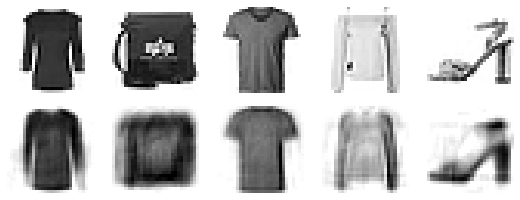

In [13]:
plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")  # extra code – saves the high res figure
plt.show()

# 3. Denoising Autoencoders <a name="3."></a>

Using dropout to remove information from the input. Then use an autoencoder to learn how to return the lost from the input. Essentially we will simply create an **image noise reduction algorithm** 


In [14]:
tf.random.set_seed(42)  #ensures reproducibility on CPU

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), #Drop half the weights at this point, ie. drop half the inputs
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

Compile and train the model!

In [15]:
dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0290 - val_loss: 0.0220
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0223 - val_loss: 0.0200
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0209 - val_loss: 0.0191
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0202 - val_loss: 0.0186
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0197 - val_loss: 0.0181
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0194 - val_loss: 0.0180
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0191 - val_loss: 0.0176
Epoch 8/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0189 - val_loss: 0.0173
Epoch 9/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.0187 - val_loss: 0.0172
Epoch 10/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.018

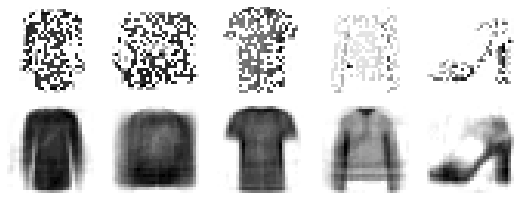

In [16]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5) #drop half the weights randomly, seed above make the results reproduceable
plot_reconstructions(dropout_ae, dropout(X_valid, training=True)) # pass model and input x dropout
save_fig("dropout_denoising_plot")
plt.show()

Brilliant! Autoencode enables us to restore noisy image!